# Controllability and Aging

In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import importlib
import sys
import os
import scipy.stats
import pickle as pkl
import matplotlib.pyplot as plt
print(sys.version)

import Towlson_group_code.data_io as myFunc
importlib.reload(myFunc)

import PREVENT_functions as prev_fct
importlib.reload(prev_fct)

PICKLE_PATH = '../../PREVENT_Study/pickles/'
FIGURE_PATH = '../../PREVENT_Study/figures/'
DUMP_PATH = '../../PREVENT_Study/dump/'
TIMES = ['bl', 'y1', 'y3', 'y5']
metadata, node_list = prev_fct.load_meta_data()
print(len(node_list))
individual_data = myFunc.load_from_pickle(PICKLE_PATH, 'Non_Normalized_Connectomes.pkl')

3.8.12 (default, Mar  2 2022, 12:59:08) 
[Clang 13.0.0 (clang-1300.0.27.3)]
150


# Check controllability value of a network G. Does it match with literature?

0.4986645158853023 0.9988879177768147
0.5389851865922186 0.9990125518788109


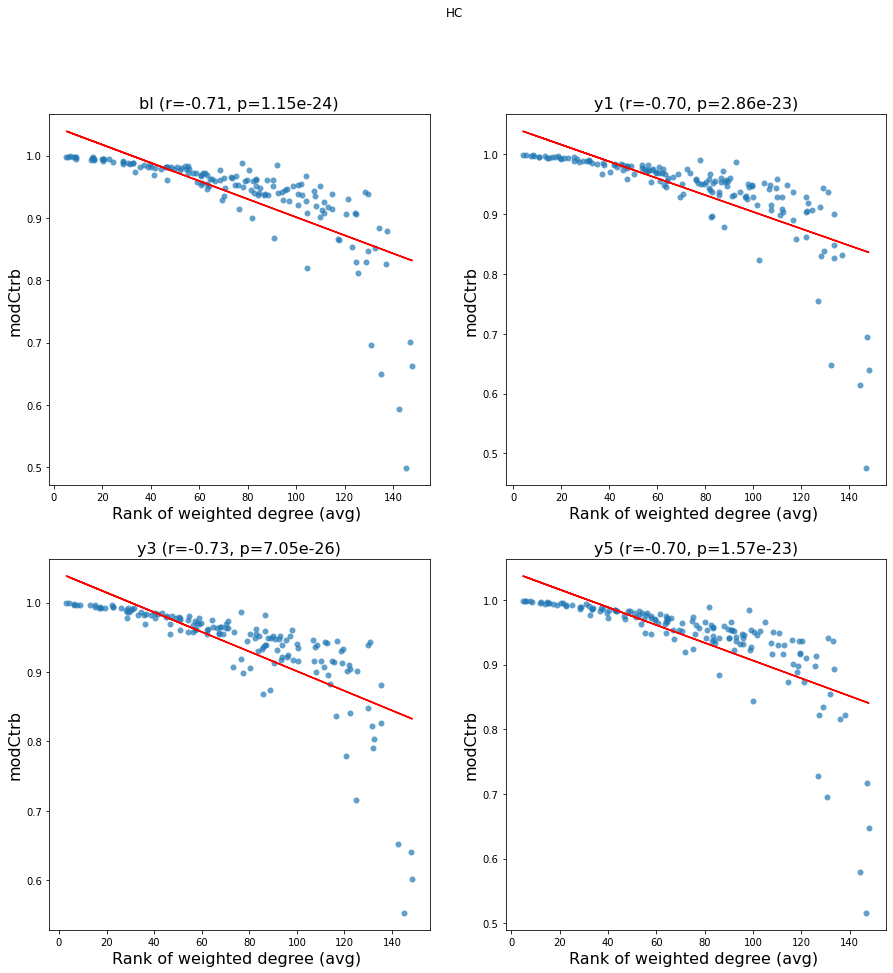

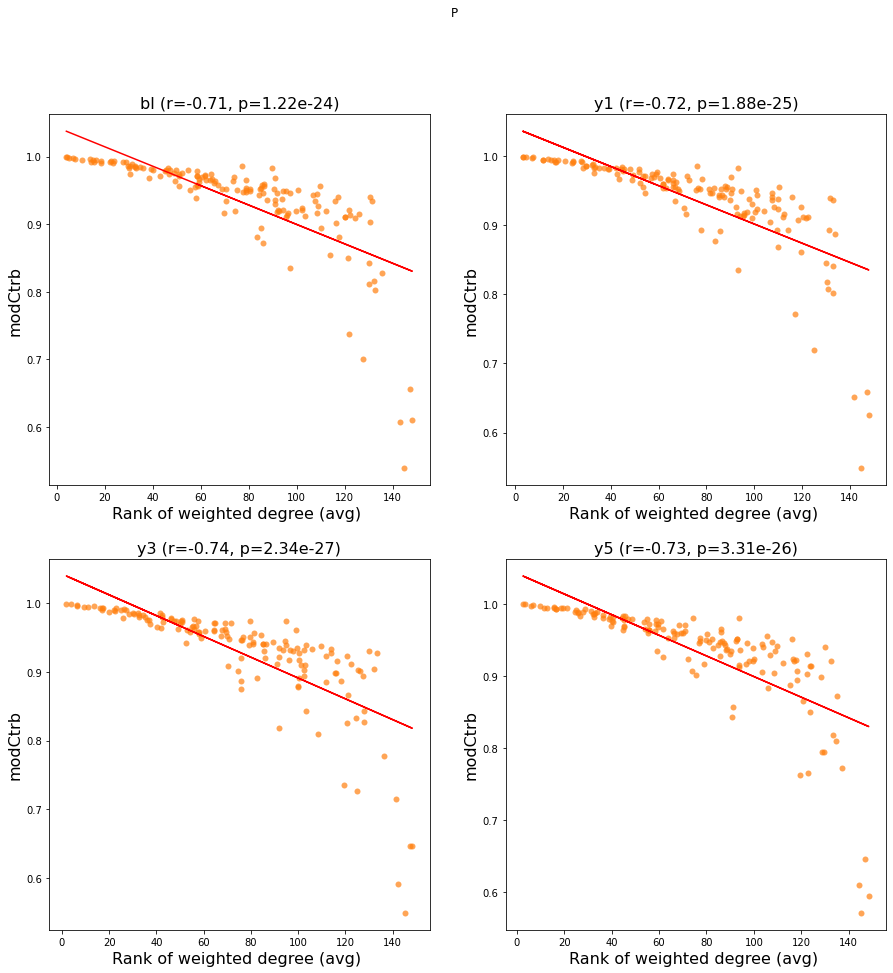

In [41]:
SAVE_FLAG = False
plot_axis = {'bl': (0,0), 'y1': (0,1), 'y3': (1,0), 'y5': (1,1)}
rank_type = 'modCtrb'
xlabel = 'Rank of weighted degree (avg) '
ylabel = f'{rank_type}'
for patient_type in ['HC', 'P']:
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    if patient_type == 'HC':
        color = "tab:blue"
    if patient_type == 'P':
        color = 'tab:orange'
    for time in ['bl', 'y1', 'y3', 'y5']:
        data = individual_data[patient_type+time]
        for pid, G in data.items():
            success, G, badRegions = prev_fct.rank_nodes(G, 'weight')
            success, G, badRegions = prev_fct.rank_nodes(G, rank_type)
        # Average ctrb. values per region
        avg_y = {r: 0.0 for r in node_list}
        avg_x = {r: 0.0 for r in node_list}
        for pid, G in data.items():
            for reg, val in nx.get_node_attributes(G, 'weightRank').items():
                avg_x[reg] += val
            for reg, val in nx.get_node_attributes(G, rank_type).items():
                avg_y[reg] += val
        n = len(data)
        y = np.array([v/n for v in avg_y.values()])
        x = np.array([v/n for v in avg_x.values()])
        slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
        fig.suptitle(patient_type)
        title = time + " " + f'(r={r:.2f}, p={p:.2e})'
        # title = time
        axs[plot_axis[time][0], plot_axis[time][1]].scatter(x, y, linewidth=0, c=color, alpha=0.7)
        axs[plot_axis[time][0], plot_axis[time][1]].plot(x, intercept + slope * x, c='red')
        axs[plot_axis[time][0], plot_axis[time][1]].set_xlabel(xlabel, fontsize=16)
        axs[plot_axis[time][0], plot_axis[time][1]].set_ylabel(ylabel, fontsize=16)
        axs[plot_axis[time][0], plot_axis[time][1]].set_title(title, fontsize=16, color='black')

        if time == 'bl':
            print(min(y), max(y))
    fig.suptitle(patient_type, color='black')
    if SAVE_FLAG:
        figName = f'{FIGURE_PATH}{patient_type}-{rank_type}.png'
        print("Saving...", figName)
        plt.savefig(figName, dpi=300, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')
        plt.close(fig)

# ICN controllability changes over 5 years
For each functional network (icn), check if there's a difference in controllability (or ctrb. rank)
in a 5 year change between TIA vs Controls.

In [42]:
from scipy.stats import mannwhitneyu

def get_avg_node_metric(G, node_list, metric):
    values = [G.nodes[node][metric] for node in node_list]
    return sum(values)/len(values)


def get_ctrb_df(rois, use_rank = False):
    ids = []
    time = []
    # age = []
    diagnosis = []
    avg_ctrb = []
    mod_ctrb = []
    for k in individual_data.keys():
        if len(k) == 4:
            ptype = k[:2]
            t = k[2:]
        else:
            ptype = k[0]
            t = k[1:]
        for pid, G in individual_data[k].items():
            diagnosis.append(ptype)
            ids.append(pid)
            time.append(t)
            # age.append(metadata.loc[pid]['Age'])
            if use_rank:
                _, G, _ = prev_fct.rank_nodes(G, 'avgCtrb')
                _, G, _ = prev_fct.rank_nodes(G, 'modCtrb')
                avg_ctrb.append(get_avg_node_metric(G, rois, 'avgCtrbRank'))
                mod_ctrb.append(get_avg_node_metric(G, rois, 'modCtrbRank'))
            else:
                avg_ctrb.append(get_avg_node_metric(G, rois, 'avgCtrb'))
                mod_ctrb.append(get_avg_node_metric(G, rois, 'modCtrb'))
    return pd.DataFrame(data = {'ID': ids, 'Time': time, 'C/T': diagnosis, 'avgCtrb': avg_ctrb, 'modCtrb': mod_ctrb})


def boxplot_atrophy_rate(plot_df, t1, t2, yrs, metric, title):
    plt.figure()
    data_y3 = plot_df[(plot_df['Time']==t2)][['ID', metric]]
    data_bl = plot_df[(plot_df['Time']==t1)][['ID', metric, 'C/T']]
    data_y3_bl = data_bl.set_index(['ID']).join(data_y3.set_index(['ID']), on='ID', lsuffix='_1', rsuffix='_2')
    data_y3_bl = data_y3_bl.dropna()
    data_y3_bl['Annual Atrophy'] = (data_y3_bl[f'{metric}_2'] - data_y3_bl[f'{metric}_1'])/yrs

    # --- Mann Whitney test ----
    _, p = mannwhitneyu(data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'], data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'], method='asymptotic', alternative="two-sided")
    if p > 0.05:
        return None

    hc_mean = data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'].mean()
    hc_std = data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'].std()
    p_mean = data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'].mean()
    p_std = data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy'].std()
    # print(f"HC (mean +- SD): {hc_mean:0.2f} +- {hc_std:0.3f}")
    # print(f"P (mean +- SD): {p_mean:0.2f} +- {p_std:0.3f}")

    bp = plt.boxplot([data_y3_bl[data_y3_bl['C/T']=='HC']['Annual Atrophy'],
                 data_y3_bl[data_y3_bl['C/T']=='P']['Annual Atrophy']])
    plt.xticks([1, 2], ['HC', 'P'])
    plt.title(f'{title.capitalize()} Annual Atrophy over {yrs} yrs (p = {p:0.3f}) ')
    plt.ylabel(f"{metric}/years")
    plt.legend([bp["boxes"][0], bp["boxes"][1]],
               [f"HC (mean +- SD): {hc_mean:0.4f} +- {hc_std:0.3f}", f"TIA (mean +- SD): {p_mean:0.4f} +- {p_std:0.3f}"],
               loc='upper center', bbox_to_anchor=(0.5, -0.08))
    plt.savefig(f'../../PREVENT_study/figures/network w aging/search/{title.capitalize()} Atrophy {t2}.png', dpi=300, edgecolor='none', bbox_inches='tight')
    plt.close()

In [43]:
node_set = set(node_list)
node_icn_map, icn_node_map = prev_fct.get_icn_map()

for icn_name, icn_nodes in icn_node_map.items():
    nodes = node_set.intersection(set(icn_nodes))
    plot_df = get_ctrb_df(nodes, use_rank=True)
    # print(plot_df)
    boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'avgCtrb', f'{icn_name} Avg Ctrb')
    boxplot_atrophy_rate(plot_df, 'bl', 'y5', 5, 'modCtrb', f'{icn_name} Mod Ctrb')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Does the strength of regional controllability correlate with the amount of change over 5 years?
- Let x-axis be the regional controllability value
- Let y-axis be the annual change over 5 years of that regional controllability value (averaged across all 5 year subjects)

In [58]:
metadata, node_list = prev_fct.load_meta_data()

In [66]:
def get_5_year_regional_ctrb(metric, ptype, use_rank = False):
    global node_list
    ctrb = []
    bl_ctrb_avg = []
    y5_data = individual_data[f'{ptype}y5']
    bl_data = individual_data[f'{ptype}bl']
    bl_ids = list(bl_data.keys())
    for pid, y5_G in y5_data.items():
        if pid not in bl_ids:
            continue
        bl_G = bl_data[pid]
        if use_rank:
            _, y5_G, _ = prev_fct.rank_nodes(y5_G, metric)
            _, bl_G, _ = prev_fct.rank_nodes(bl_G, metric)
            y5_ctrb = np.array([y5_G.nodes[node][metric + 'Rank'] for node in node_list])
            bl_ctrb = np.array([bl_G.nodes[node][metric + 'Rank'] for node in node_list])
        else:
            y5_ctrb = np.array([y5_G.nodes[node][metric] for node in node_list])
            bl_ctrb = np.array([bl_G.nodes[node][metric] for node in node_list])
        bl_ctrb_avg.append(bl_ctrb)
        ctrb.append((y5_ctrb - bl_ctrb)/5)
    ctrb_narray = np.array(ctrb)
    bl_ctrb_narray = np.array(bl_ctrb_avg)
    return np.mean(bl_ctrb_narray, axis=0), np.mean(ctrb_narray, axis=0)

Use controllability rank instead because the rank gives us more information on whether the controllability changes over
5 years is more for nodes with higher avg rank / lower avg rank.
- If yearly atrophy is more targeted towards higher avg rank nodes, then we expect to see a cone like <
- If yearly atrophy is more targeted towards lower avg rank nodes, then we expect to see a cone like >
- If neither case above occur then we know aging isn't targeting high ctrb. nodes.
    - problem: how can we use controllability then for this project?

In [67]:
SAVE_FLAG = True
ylabel = 'Rank Annual atrophy over 5 years'
time = 'y5'
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plot_axis = {'avgCtrb': 0, 'modCtrb': 1}
for rank_type in ['avgCtrb', 'modCtrb']:
    for patient_type in ['HC', 'P']:
        if patient_type == 'HC':
            color = "tab:blue"
        if patient_type == 'P':
            color = 'tab:orange'
        x, y = get_5_year_regional_ctrb(rank_type, patient_type, use_rank=True)

        # slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
        # title = time + " " + f'(r={r:.2f}, p={p:.2e})'
        xlabel = f'Regional {rank_type} Rank'
        axs[plot_axis[rank_type]].scatter(x, y, linewidth=0, c=color, alpha=0.7)
        # axs[plot_axis[patient_type][0], plot_axis[patient_type][1]].plot(x, intercept + slope * x, c='red')
        axs[plot_axis[rank_type]].set_xlabel(xlabel, fontsize=16)
        axs[plot_axis[rank_type]].set_ylabel(ylabel, fontsize=16)

if SAVE_FLAG:
    figName = FIGURE_PATH + '5_year_regional_ctrb_atrophy.png'
    print("Saving...", figName)
    plt.savefig(figName, dpi=300, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')
    plt.close(fig)
else:
    plt.show()

Saving... ../../PREVENT_Study/figures/5_year_regional_ctrb_atrophy.png


For regions that have high annual atrophy, what is the difference between Control and TIA? What is the
p value after Bonferroni correction?

Found something?!
Found something?!
Found something?!
Found something?!
Found something?!
Found something?!
Found something?!
Found something?!
Found something?!
Saving... ../../PREVENT_Study/figures/5_year_regional_mod_ctrb_atrophy_significant.png


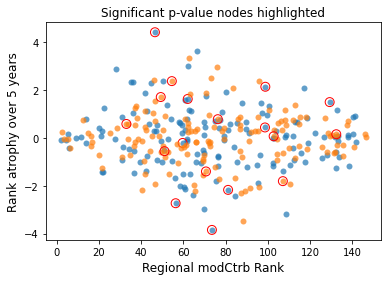

In [88]:
SAVE_FLAG = True
use_rank = True
ylabel = 'Rank Annual atrophy over 5 years'
metric = 'modCtrb'

ctrb_atrophy = {'HC': None,'P': None}
for ptype in ['HC', 'P']:
    ctrb = []
    y5_data = individual_data[f'{ptype}y5']
    bl_data = individual_data[f'{ptype}bl']
    bl_ids = list(bl_data.keys())
    for pid, y5_G in y5_data.items():
        if pid not in bl_ids:
            continue
        bl_G = bl_data[pid]
        if use_rank:
            _, y5_G, _ = prev_fct.rank_nodes(y5_G, metric)
            _, bl_G, _ = prev_fct.rank_nodes(bl_G, metric)
            y5_ctrb = np.array([y5_G.nodes[node][metric + 'Rank'] for node in node_list])
            bl_ctrb = np.array([bl_G.nodes[node][metric + 'Rank'] for node in node_list])
        else:
            y5_ctrb = np.array([y5_G.nodes[node][metric] for node in node_list])
            bl_ctrb = np.array([bl_G.nodes[node][metric] for node in node_list])
        ctrb.append((y5_ctrb - bl_ctrb)/5)
    ctrb_atrophy[ptype] = pd.DataFrame(data=ctrb)
    ctrb_atrophy[ptype].rename(columns={i:name for i, name in enumerate(node_list)}, inplace=True)

sig_nodes = []
# For each node, do manwhitney test for p value.
for i, node in enumerate(node_list):
    _, p = mannwhitneyu(ctrb_atrophy['HC'][node], ctrb_atrophy['P'][node], method='asymptotic', alternative="two-sided")
    if p > 0.05:
        continue
    print("Found something?!")
    sig_nodes.append(i)
    # hc_mean = ctrb_atrophy['HC'][node].mean()
    # hc_std = ctrb_atrophy['HC'][node].std()
    # p_mean = ctrb_atrophy['P'][node].mean()
    # p_std = ctrb_atrophy['P'][node].std()

    # plt.figure()
    # bp = plt.boxplot([ctrb_atrophy['HC'][node], ctrb_atrophy['P'][node]])
    # plt.xticks([1, 2], ['HC', 'P'])
    # plt.title(f'{node.capitalize()} Annual Atrophy over 5 yrs (p* = {p:0.3f}) ')
    # plt.ylabel(f"{metric} Rank/year")
    # plt.legend([bp["boxes"][0], bp["boxes"][1]],
    #            [f"HC (mean +- SD): {hc_mean:0.4f} +- {hc_std:0.3f}",
    #             f"TIA (mean +- SD): {p_mean:0.4f} +- {p_std:0.3f}"],
    #            loc='upper center', bbox_to_anchor=(0.5, -0.08))
    # # plt.savefig(f'../../PREVENT_study/figures/{node.capitalize()} Atrophy.png', dpi=300, edgecolor='none', bbox_inches='tight')
    # # plt.close()
    # plt.show()

ylabel = 'Rank atrophy over 5 years'
for patient_type in ['HC', 'P']:
    if patient_type == 'HC':
        color = "tab:blue"
    if patient_type == 'P':
        color = 'tab:orange'
    x, y = get_5_year_regional_ctrb(metric, patient_type, use_rank=True)
    x_sig = [x[i] for i in sig_nodes]
    y_sig = [y[i] for i in sig_nodes]

    xlabel = f'Regional {metric} Rank'
    plt.scatter(x, y, linewidth=0, c=color, alpha=0.7)
    plt.scatter(x_sig, y_sig, s=80, facecolors='none', edgecolors='r')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title("Significant p-value nodes highlighted", fontsize=12)

if SAVE_FLAG:
    figName = FIGURE_PATH + '5_year_regional_mod_ctrb_atrophy_significant.png'
    print("Saving...", figName)
    plt.savefig(figName, dpi=300, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')
    plt.close(fig)
else:
    plt.show()